**Natural Language Processing with Disaster Tweets**

Predict which Tweets are about real disasters and which ones are not


*Exploring NLP with HuggingFace Transformers*

In [13]:
# Importing Libraries

import os
import re
import math
import string
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf

from wordcloud import STOPWORDS

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [14]:
BATCH_SIZE = 16

EPOCHS = 5

CLEAN_TWEETS = False

USE_META = True

ADD_DENSE = False
DENSE_DIM = 64

ADD_DROPOUT = True
DROPOUT = .2

TRAIN_BASE = True

In [15]:
#Mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#Get Data
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')

In [18]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

**PRE PROCESSING**

In [20]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))

#define function to expand contractions and showcase
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [21]:
#This stips tweet related characters
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

#Check functionality
strip_all_entities('@shawn Titanic #tragedy could have been prevented Economic Times: Telegraph.co.uk Titanic tragedy could have been prevented... http://bet.ly/tuN2wx')

'Titanic tragedy could have been prevented Economic Times Telegraph co uk Titanic tragedy could have been prevented'

In [22]:
#this removes stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in STOPWORDS])

In [23]:
#apply to Tweets
if CLEAN_TWEETS:
    for df in [train, test]:
        df['text'] = df['text'].apply(expand_contractions)
        df['text'] = df['text'].apply(strip_all_entities)
        df['text'] = df['text'].apply(remove_stopwords)

**META FEATURES**

In [24]:
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

In [25]:
for df in [train, test]:
    df['word count'] = df['text'].apply(lambda x: len(x.split()))
    df['character count'] = df['text'].apply(lambda x: len(x))
    df['average word length'] = df['text'].apply(average_word_length)
    df['unique word count'] = df['text'].apply(lambda x: len(set(x.split())))
    df['stopword count'] = df['text'].apply(lambda x: len([i for i in x.lower().split() if i in STOPWORDS]))
    #df['punctuation count'] = df['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))
    df['stopword ratio'] = df['stopword count'] / df['word count']
    df['url count'] = df['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

In [26]:
meta_train = StandardScaler().fit_transform(train.iloc[:, 2:])
meta_test = StandardScaler().fit_transform(test.iloc[:, 1:])

#meta_train = MinMaxScaler().fit_transform(train.iloc[:, 2:])
#meta_test = MinMaxScaler().fit_transform(test.iloc[:, 1:])

**DIFFERENT TOKENIZERS**

*Explore how the different transformer models in HuggingFace tokenize text:*

In [27]:
pip install transformers

     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 40.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.0 MB/s 
     |████████████████████████████████| 61 kB 501 kB/s 
     |████████████████████████████████| 596 kB 49.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [28]:
#BERT
from transformers import BertTokenizer
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Encode: [101, 4372, 16044, 2033, 999, 102]
Decode: [CLS] encode me! [SEP]


In [29]:
#RoBERTa
from transformers import RobertaTokenizer
TOKENIZER = RobertaTokenizer.from_pretrained("roberta-base")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Encode: [0, 16040, 20414, 162, 328, 2]
Decode: <s>Encode me!</s>


In [30]:
% pip install sentencepiece

     |████████████████████████████████| 1.2 MB 3.8 MB/s 


In [31]:
#BART
from transformers import BartTokenizer
TOKENIZER = BartTokenizer.from_pretrained('facebook/bart-large')
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Encode: [0, 16040, 20414, 162, 328, 2]
Decode: <s>Encode me!</s>


In [32]:
#ELECTRA and BERT have identical tokenizers
from transformers import BertTokenizer
TOKENIZER = BertTokenizer.from_pretrained('google/electra-base-generator')
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Encode: [101, 4372, 16044, 2033, 999, 102]
Decode: [CLS] encode me! [SEP]


**BERT**

In [33]:
import tensorflow as tf
from transformers import TFBertModel, BertModel

In [34]:
#get BERT layer
bert_base = TFBertModel.from_pretrained('bert-base-uncased')
#bert_base = BertModel.from_pretrained('bert-base-uncased')          #to use with PyTorch

#select BERT tokenizer
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [35]:
def bert_encode(data,maximum_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = TOKENIZER.encode_plus(data.text[i],
                                        add_special_tokens=True,
                                        max_length=maximum_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [36]:
def build_model(model_layer, learning_rate, use_meta = USE_META, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    meta_input = tf.keras.Input(shape = (meta_train.shape[1], ))
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    output = transformer_layer[1]
    
    #add meta data
    if use_meta:
        output = tf.keras.layers.Concatenate()([output, meta_input])
    
    #add dense relu layer
    if add_dense:
        print("Training with additional dense layer...")
        output = tf.keras.layers.Dense(dense_dim,activation='relu')(output)
    
    #add dropout
    if add_dropout:
        print("Training with dropout...")
        output = tf.keras.layers.Dropout(dropout)(output)
    
    #add final node for binary classification
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    #assemble and compile
    if use_meta:
        print("Training with meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks, meta_input],outputs = output)
    
    else:
        print("Training without meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [37]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'], color = '#171820')
    ax[0].plot(history.history['val_accuracy'], color = '#fdc029')

    ax[1].plot(history.history['loss'], color='#171820')
    ax[1].plot(history.history['val_loss'], color = '#fdc029')

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Learning Curves", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [38]:
if TRAIN_BASE:
    #get our inputs
    print('Encoding Tweets...')
    train_input_ids,train_attention_masks = bert_encode(train,60)
    test_input_ids,test_attention_masks = bert_encode(test,60)
    print('Tweets encoded')
    print('')

    #debugging step
    print('Train length:', len(train_input_ids))
    print('Test length:', len(test_input_ids))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Encoding Tweets...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tweets encoded

Train length: 7613
Test length: 3263


In [39]:
#and build and view parameters
BERT_base = build_model(bert_base, learning_rate = 1e-5)
BERT_base.summary()

Training with dropout...
Training with meta-data...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(N

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('base_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [41]:
#train BERT
if TRAIN_BASE:
    if USE_META:
        history = BERT_base.fit([train_input_ids,train_attention_masks, meta_train], train.target, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
    
    else:
        history = BERT_base.fit([train_input_ids,train_attention_masks], train.target, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)   

Epoch 1/5
381/381 [==============================] - 200s 474ms/step - loss: 0.4625 - accuracy: 0.7892 - val_loss: 0.3860 - val_accuracy: 0.8437
Epoch 2/5
381/381 [==============================] - 176s 461ms/step - loss: 0.3523 - accuracy: 0.8578 - val_loss: 0.4068 - val_accuracy: 0.8411
Epoch 3/5
381/381 [==============================] - 175s 461ms/step - loss: 0.2896 - accuracy: 0.8877 - val_loss: 0.4137 - val_accuracy: 0.8280
Epoch 4/5
381/381 [==============================] - 175s 461ms/step - loss: 0.2216 - accuracy: 0.9194 - val_loss: 0.5020 - val_accuracy: 0.8162
Epoch 5/5
381/381 [==============================] - 176s 461ms/step - loss: 0.1685 - accuracy: 0.9412 - val_loss: 0.5125 - val_accuracy: 0.8372


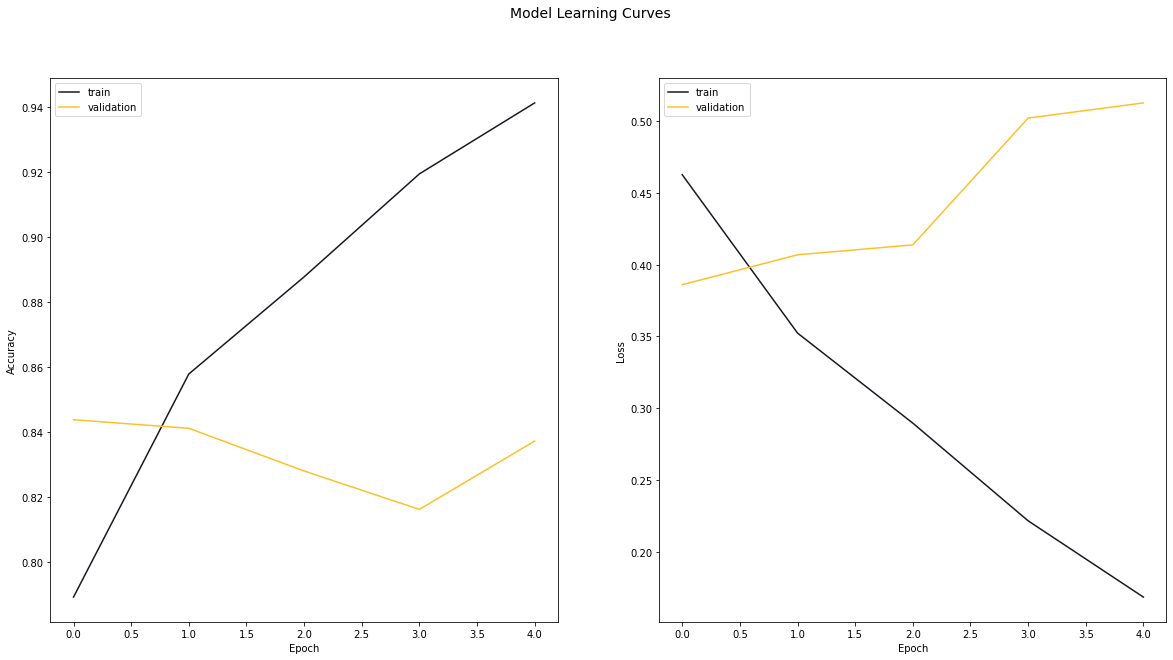

In [42]:
if TRAIN_BASE:
    plot_learning_curves(history)

In [43]:
#load model with best losses
if TRAIN_BASE:
    BERT_base.load_weights('base_model.h5') 

In [44]:
#predict with BERT
if TRAIN_BASE:
    if USE_META:
        preds_base = BERT_base.predict([test_input_ids,test_attention_masks,meta_test])

    else:
        preds_base = BERT_base.predict([test_input_ids,test_attention_masks])

In [45]:
#save as dataframe
if TRAIN_BASE:
    submission_base = pd.DataFrame()
    submission_base['id'] = test_id
    submission_base['prob'] = preds_base
    submission_base['target'] = np.round(submission_base['prob']).astype(int)
    submission_base.head(10)

In [46]:
if TRAIN_BASE:
    submission_base = submission_base[['id', 'target']]

    #save to disk
    submission_base.to_csv('submission_bert_base.csv', index = False)
    print('Submission saved')

Submission saved
